# Notebook Disclaimer

This notebook is based on open-access code shared by Martin Görner on GitHub. The original source code can be found at [https://github.com/GoogleCloudPlatform/practical-ml-vision-book/tree/master/05_create_dataset].

**Disclaimer:** This notebook is for educational purposes and follows the principles of fair use. The code is the intellectual property of the original author, and any modifications or adaptations made here are done solely for learning and personal use. All credits for the original code go to Martin Görner.

Please refer to the original repository for detailed explanations, and support the author by exploring their work on [https://github.com/GoogleCloudPlatform/practical-ml-vision-book].

---


# Create TensorFlow Record

In [1]:
#!pip  install tensorflow

In [17]:
import tensorflow as tf
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import keras

### Helper Function

In [3]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [4]:
# Function to convert image file to TensorFlow Example
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Function to create a TFRecord file
def create_tfrecord(images_folder, output_file):
    writer = tf.io.TFRecordWriter(output_file)

    # List all subdirectories (assuming each subdirectory is a class)
    classes = os.listdir(images_folder)

    for class_name in classes:
        class_path = os.path.join(images_folder, class_name)
        if not os.path.isdir(class_path):
            continue

        # Get list of image files in the class folder
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_file in tqdm(image_files, desc=f"Processing {class_name}"):
            image_path = os.path.join(class_path, image_file)

            # Read the original image without resizing
            image = Image.open(image_path)
            image = np.array(image)
            label = classes.index(class_name)

            # Create a TensorFlow Example
            feature = {
                'image': _bytes_feature(image),
                'label': _int64_feature(label),
            }
            example_proto = tf.train.Example(features=tf.train.Features(feature=feature))

            # Write the Example to the TFRecord file
            writer.write(example_proto.SerializeToString())

    writer.close()

# --- TRAIN TFRecord
# Specify your input folder containing class subfolders (e.g., "class_1", "class_2")
train_folder = r"C:\Users\User\Desktop\GithubProjects\practical-ml-vision\Creating_datasets\train"
# Specify the output TFRecord file
train_tfrecord = r"C:\Users\User\Desktop\GithubProjects\practical-ml-vision\Creating_datasets\train.tfrecord"

# Create TFRecord file
create_tfrecord(train_folder, train_tfrecord)

# --- TRAIN TFRecord
# Specify your input folder containing class subfolders (e.g., "class_1", "class_2")
val_folder = r"C:\Users\User\Desktop\GithubProjects\practical-ml-vision\Creating_datasets\val"
# Specify the output TFRecord file
val_tfrecord = r"C:\Users\User\Desktop\GithubProjects\practical-ml-vision\Creating_datasets\val.tfrecord"

# Create TFRecord file
create_tfrecord(val_folder, val_tfrecord)

Processing pug: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.11it/s]


### Parse TensorFlow Record

In [5]:
# Function to parse TFRecord
def parse_tfrecord(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    rec = tf.io.parse_single_example(proto, feature_description)

    # Decode the image from bytes
    img = tf.io.decode_jpeg(rec['image'], channels=3)
    label = rec['label']

    return img, label

# Create a TFRecordDataset from the output file
tfrecord_dataset = tf.data.TFRecordDataset([train_tfrecord])

# Map the parse function to the dataset
parsed_dataset = tfrecord_dataset.map(parse_tfrecord)

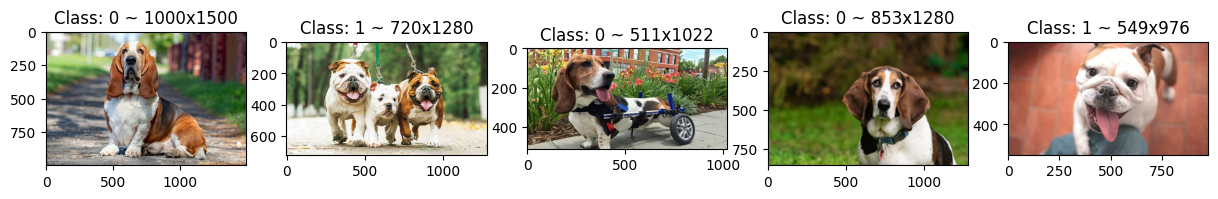

In [6]:
# Shuffle the dataset 
buffer_size = 10000
shuffled_dataset = parsed_dataset.shuffle(buffer_size)

# Iterate through the parsed dataset
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(shuffled_dataset.take(5)):
    #print(img.shape)
    mean_of_image = tf.reduce_mean(img)
    # print(mean_of_image)
    # print(label_int)
    ax[idx].imshow((img.numpy()));
    ax[idx].set_title('Class: {} ~ {}x{}'.format(label_int.numpy(), img.shape[0], img.shape[1]))

### Resize images

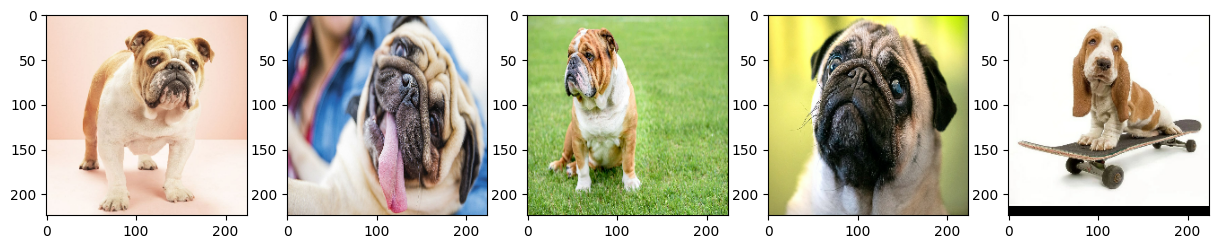

In [7]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(
        height=IMG_HEIGHT, width=IMG_WIDTH,
        input_shape=(None, None, 3))
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0) #Note: This expanding is because we have images of different sizes
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)

    # Cast to integer
    x = tf.cast(x, tf.uint8)
    
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(shuffled_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()))
    #ax[idx].set_title('Class: {} ~ {}x{}'.format(label_int.numpy(), img.shape[0], img.shape[1]))

## Resize keeping aspect ratio

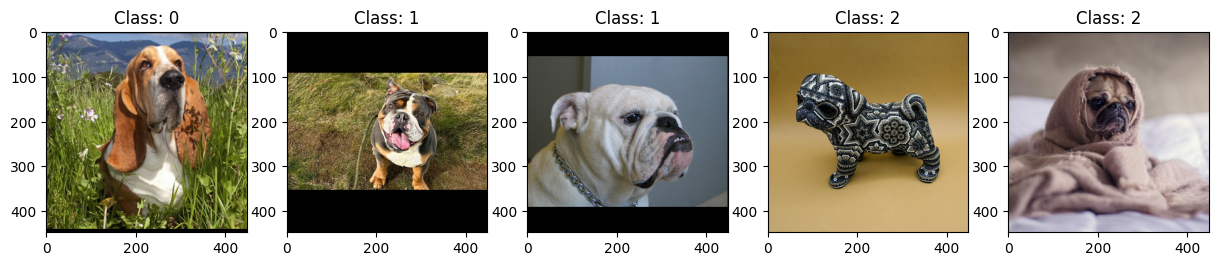

In [8]:
def apply_preproc(img, label):
    x = tf.image.resize_with_pad(img, 2*IMG_HEIGHT, 2*IMG_WIDTH)
    # Cast to integer
    x = tf.cast(x, tf.uint8)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(shuffled_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title('Class: {}'.format(label_int.numpy()))

## Resizing by center cropping

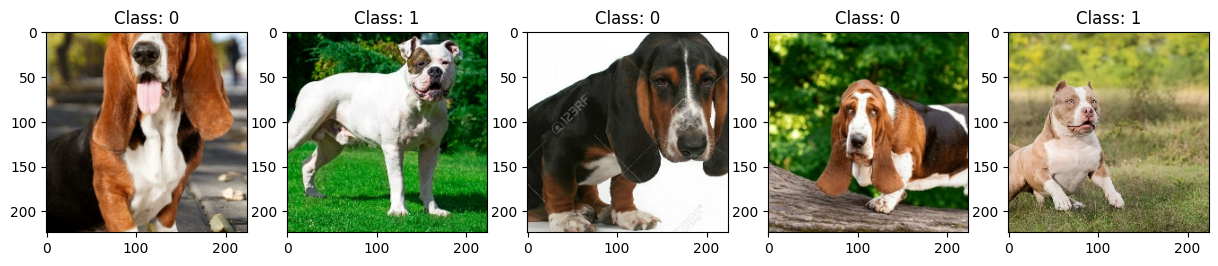

In [9]:
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda img:
                           tf.image.resize_with_pad(
                               img, 2*IMG_HEIGHT, 2*IMG_WIDTH),
                           input_shape=(None, None, 3)),
    tf.keras.layers.experimental.preprocessing.CenterCrop(
        height=IMG_HEIGHT, width=IMG_WIDTH)
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    # Cast to integer
    x = tf.cast(x, tf.uint8)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(shuffled_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title('Class: {}'.format(label_int.numpy()))

### Full pipeline
Batch the dataset will al images of the same size

In [10]:
NUM_CLASSES=3
# Function to map labels to one-hot encoded format
def map_labels(img, label):
    one_hot_label = tf.one_hot(label, depth=NUM_CLASSES)
    return img, one_hot_label

In [18]:
batch_size = 4
IMG_CHANNELS=3

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 4,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = shuffled_dataset.map(apply_preproc).map(map_labels).batch(batch_size)
    # Note: val dataset was not loaded
    eval_dataset = tf.data.TFRecordDataset(
        [val_tfrecord]).map(parse_tfrecord).shuffle(buffer_size).map(
        apply_preproc).map(map_labels).batch(batch_size)

    # Define model
    layers_ = [
        layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='input_layer'),
        layers.Flatten(name='flatten_layer'),
        layers.Dense(num_hidden,
                    kernel_regularizer=regularizer, 
                    activation=tf.keras.activations.relu,
                    name='dense_hidden_1'),
        layers.Dense(num_hidden,
                    kernel_regularizer=regularizer, 
                    activation=tf.keras.activations.relu,
                    name='dense_hidden_2'),
        layers.Dense(NUM_CLASSES,  
                    activation='softmax', 
                    name='breed_prob')
    ]
    # Create model
    model = keras.Sequential(layers_, name='dog_breed_classification')
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
            loss=tf.keras.losses.CategoricalCrossentropy(
                from_logits=False),
            metrics=['accuracy'])
    # Show model layers
    
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "dog_breed_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 150528)            0         
                                                                 
 dense_hidden_1 (Dense)      (None, 16)                2408464   
                                                                 
 dense_hidden_2 (Dense)      (None, 16)                272       
                                                                 
 breed_prob (Dense)          (None, 3)                 51        
                                                                 
Total params: 2408787 (9.19 MB)
Trainable params: 2408787 (9.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10


51/51 [==============================] - 7s 87ms/step - loss: 2248.8120 - accuracy: 0.3350 - val_loss: 67.3649 - val_a

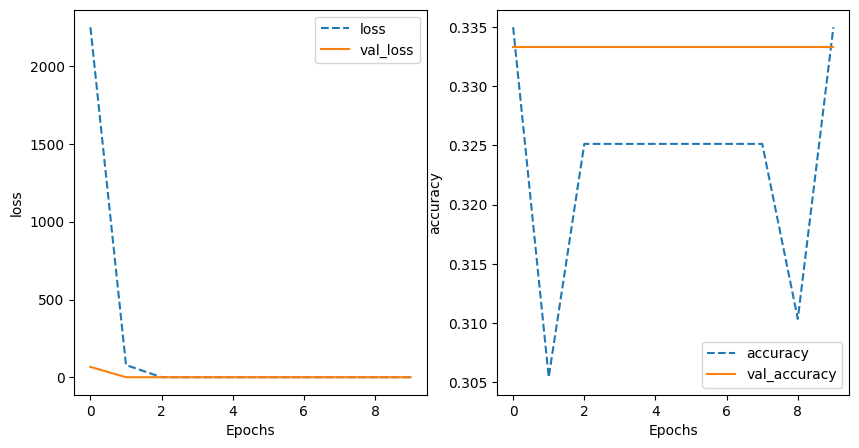

In [19]:
model = train_and_evaluate()

## Ways to avoid Trainind-serving skew

#### Resuing Functions

In [162]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

class _Preprocessor:    
    def __init__(self):
        self.preproc_layers = tf.keras.Sequential([
            tf.keras.layers.Lambda(
                lambda img: tf.image.resize_with_pad(
                    img, 2*IMG_HEIGHT, 2*IMG_WIDTH), 
                input_shape=(None, None, 3)),
            tf.keras.layers.experimental.preprocessing.CenterCrop(
                height=IMG_HEIGHT, width=IMG_WIDTH)
        ])
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        }
        rec = tf.io.parse_single_example(proto, feature_description)
    
        # Decode the image from bytes
        img = tf.io.decode_jpeg(rec['image'], channels=3)
        label = rec['label']
        return img, label
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        #img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        # add to a batch, call preproc, remove from batch
        x = tf.expand_dims(img, 0)
        x = self.preproc_layers(x)
        x = tf.squeeze(x, 0)
        # Cast to integer
        x = tf.cast(x, tf.uint8)
        return x


# """
# # Specify the output TFRecord file
# train_tfrecord = r"C:\Users\User\Desktop\GithubProjects\practical-ml-vision\Creating_datasets\train.tfrecord"

# # Create TFRecord file
# create_tfrecord(train_folder, train_tfrecord)

# # Create a TFRecordDataset from the output file
# tfrecord_dataset = tf.data.TFRecordDataset([train_tfrecord])
# """
pattern =  tf.data.TFRecordDataset([train_tfrecord])
def create_preproc_dataset(pattern):
    preproc = _Preprocessor()
    trainds = pattern.map(preproc.read_from_tfr).map(
        lambda img, label: (preproc.preprocess(img), label))                             
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)

In [163]:
df_from_function = create_preproc_dataset(pattern)

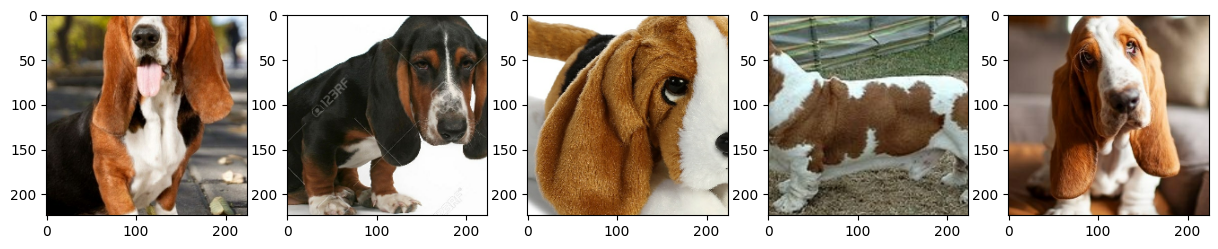

In [164]:
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(df_from_function.take(5)):
    ax[idx].imshow((img.numpy()))

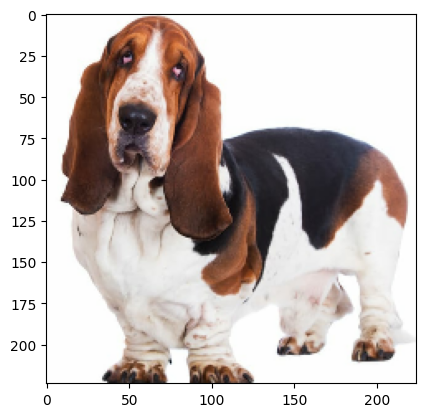

In [165]:
# Testing single image
filename = r"C:\Users\User\Desktop\GithubProjects\practical-ml-vision\Creating_datasets\train\basset\5ca61ebeb37c9443276800.jpg"
img = create_preproc_image(filename)
img = tf.image.convert_image_dtype(img, np.uint8)
plt.imshow(img)
plt.show()

#### Processing within the model

In [233]:
class _Preprocessor:    
    def __init__(self):
        # Nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        }
        rec = tf.io.parse_single_example(proto, feature_description)
    
        # Decode the image from bytes
        img = tf.io.decode_jpeg(rec['image'], channels=3)
        label = rec['label']
        return img, label
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img

    # NOTE: This reshape could be in proc_layer. The reason do it before is because
    # keras layers require same image shape. However, we can pass (None, None, Channel) as input
    def preprocess(self, img):
        return tf.image.resize_with_pad(img, 2*IMG_HEIGHT, 2*IMG_WIDTH)
        # # add to a batch, call preproc, remove from batch
        # x = tf.expand_dims(img, 0)
        # x = self.preproc_layers(x)
        # x = tf.squeeze(x, 0)
        # # Cast to integer
        # x = tf.cast(x, tf.uint8)
        # return x

Modify the Keras model

In [154]:
NUM_CLASSES=3
# Function to map labels to one-hot encoded format
def map_labels(img, label):
    one_hot_label = tf.one_hot(label, depth=NUM_CLASSES)
    return img, one_hot_label

In [149]:
batch_size = 4
IMG_CHANNELS=3

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 4,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    # train_dataset = shuffled_dataset.map(apply_preproc).map(map_labels).batch(batch_size)
    train_dataset = create_preproc_dataset(pattern).map(map_labels).batch(batch_size)
    #TODO: Adapt eval_dataset
    eval_dataset = create_preproc_dataset(pattern).map(map_labels).batch(batch_size)
    
    layers_ = [
        tf.keras.layers.CenterCrop(
            height=IMG_HEIGHT, width=IMG_WIDTH,
            input_shape=(2*IMG_HEIGHT, 2*IMG_WIDTH, IMG_CHANNELS), name="proc_layer"),
        #layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='input_layer'),
        layers.Flatten(name='flatten_layer'),
        layers.Dense(num_hidden,
                    kernel_regularizer=regularizer, 
                    activation=tf.keras.activations.relu,
                    name='dense_hidden_1'),
        layers.Dense(num_hidden,
                    kernel_regularizer=regularizer, 
                    activation=tf.keras.activations.relu,
                    name='dense_hidden_2'),
        layers.Dense(NUM_CLASSES,  
                    activation='softmax', 
                    name='breed_prob')
    ]

    # Create model
    model = keras.Sequential(layers_, name='dog_breed_classification')
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
            loss=tf.keras.losses.CategoricalCrossentropy(
                from_logits=False),
            metrics=['accuracy'])
    # Show model layers
    
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "dog_breed_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 proc_layer (CenterCrop)     (None, 224, 224, 3)       0         
                                                                 
 flatten_layer (Flatten)     (None, 150528)            0         
                                                                 
 dense_hidden_1 (Dense)      (None, 16)                2408464   
                                                                 
 dense_hidden_2 (Dense)      (None, 16)                272       
                                                                 
 breed_prob (Dense)          (None, 3)                 51        
                                                                 
Total params: 2408787 (9.19 MB)
Trainable params: 2408787 (9.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

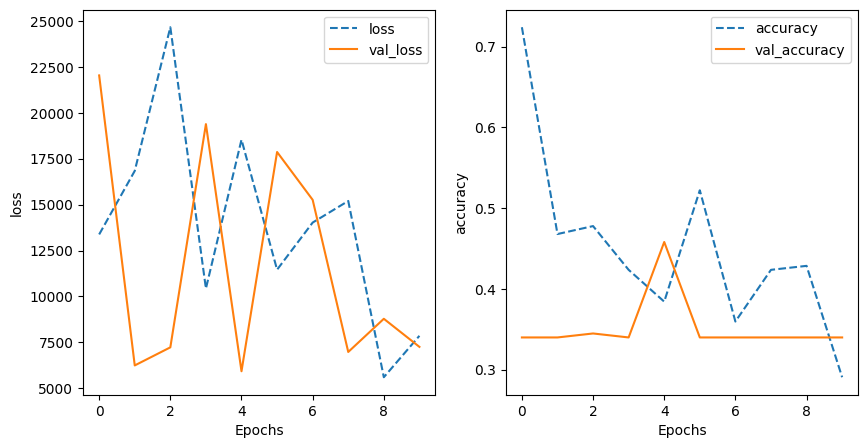

In [150]:
model = train_and_evaluate()

## Data Agumentation

In [204]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 4,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    # train_dataset = shuffled_dataset.map(apply_preproc).map(map_labels).batch(batch_size)
    train_dataset = create_preproc_dataset(pattern).map(map_labels).batch(batch_size)
    #TODO: Adapt eval_dataset
    eval_dataset = create_preproc_dataset(pattern).map(map_labels).batch(batch_size)
    
    layers_ = [
        tf.keras.layers.CenterCrop(
            height=IMG_HEIGHT, width=IMG_WIDTH,
            input_shape=(2*IMG_HEIGHT, 2*IMG_WIDTH, IMG_CHANNELS), name="centerCrop"),
      tf.keras.layers.RandomCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          name='random/center_crop'
      ),
      tf.keras.layers.RandomFlip(
          mode='horizontal',
          name='random_lr_flip/none'
      ),
        layers.Flatten(name='flatten_layer'),
        layers.Dense(num_hidden,
                    kernel_regularizer=regularizer, 
                    activation=tf.keras.activations.relu,
                    name='dense_hidden_1'),
        layers.Dense(num_hidden,
                    kernel_regularizer=regularizer, 
                    activation=tf.keras.activations.relu,
                    name='dense_hidden_2'),
        layers.Dense(NUM_CLASSES,  
                    activation='softmax', 
                    name='breed_prob')
    ]

    # Create model
    model = keras.Sequential(layers_, name='dog_breed_classification')
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
            loss=tf.keras.losses.CategoricalCrossentropy(
                from_logits=False),
            metrics=['accuracy'])
    # Show model layers
    
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    return model

model = train_and_evaluate()

Model: "dog_breed_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 centerCrop (CenterCrop)     (None, 224, 224, 3)       0         
                                                                 
 random/center_crop (Random  (None, 112, 112, 3)       0         
 Crop)                                                           
                                                                 
 random_lr_flip/none (Rando  (None, 112, 112, 3)       0         
 mFlip)                                                          
                                                                 
 flatten_layer (Flatten)     (None, 37632)             0         
                                                                 
 dense_hidden_1 (Dense)      (None, 16)                602128    
                                                                 
 dense_hidden_2 (Dense)      (None, 16)   

ValueError: in user code:

    File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "dog_breed_classification" is incompatible with the layer: expected shape=(None, 448, 448, 3), found shape=(None, 224, 224, 3)


Custom layer to augment brightness and contrast

In [181]:
class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5], 
                 brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        #images = tf.clip_by_value(images, 0, 1)
        return images

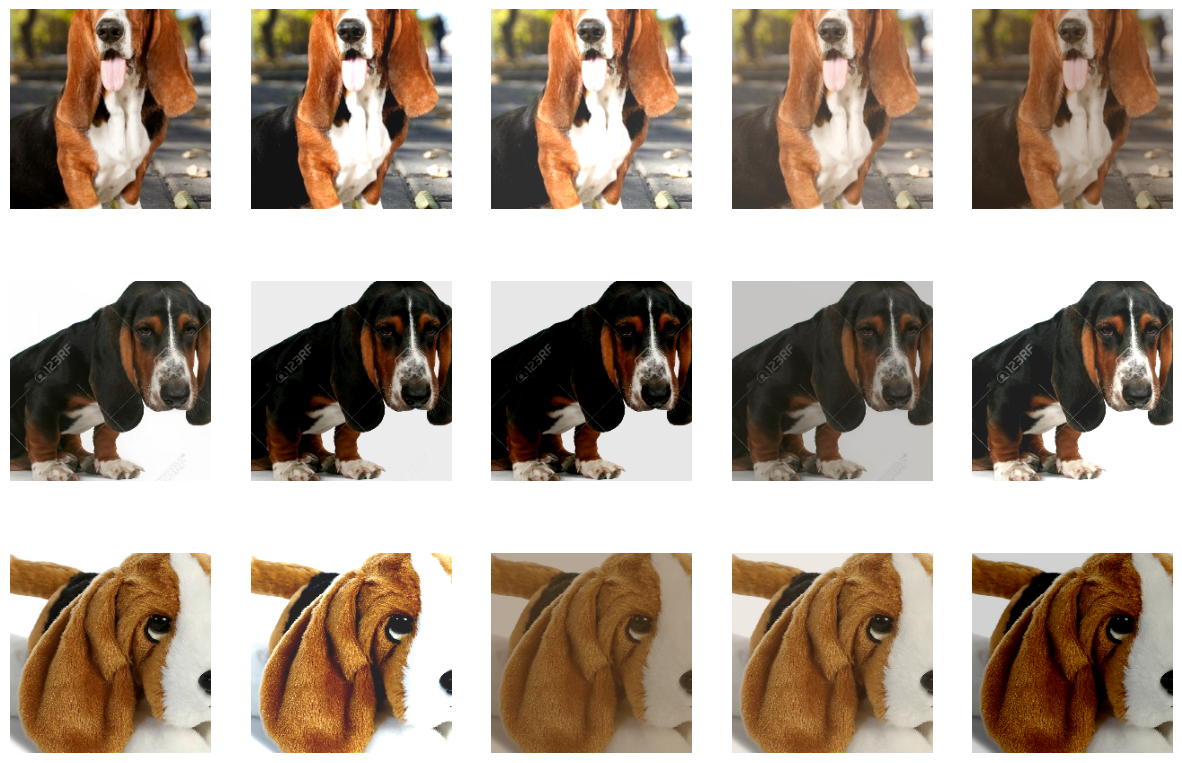

In [182]:
layer=RandomColorDistortion()
trainds = df_from_function
f, ax = plt.subplots(3, 5, figsize=(15,10))
for rowno, (img, label) in enumerate(trainds.take(3)):
    ax[rowno, 0].imshow((img.numpy()));
    ax[rowno, 0].axis('off')
    for idx in range(1, 5):
        aug = layer(img, training=True)
        #aug = tf.image.convert_image_dtype(aug*, np.uint8)
        ax[rowno, idx].imshow((aug.numpy()));
        ax[rowno, idx].axis('off')